<a href="https://colab.research.google.com/github/markdevine/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity2_Mark_Devine_19187289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "19187289" #@param {type:"string"}
Student_full_name = "Mark Devine" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# expand the display of the notebook when run

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

### Loading the house price dataset

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Path, copy the path from your Drive
path = '/content/drive/MyDrive/Colab Notebooks/Data/house/'

# training, test and cost dataset file names: 
filename1 = 'house_train.csv'
train_data = path + filename1
# test dataset: 
filename2 = 'house_test.csv'
test_data = path + filename2
# cost dataset: 
filename3 = 'true_price.csv'
cost_data = path + filename3

# load the comma-separated values (csv) files into dataframes
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)
df_cost = pd.read_csv(cost_data)


# test data
# df_test = pd.read_csv(test_data)
# X_test_original = df_test.drop("label",axis=1).values
# y_test = df_test.label.values
# print(X_test_original.shape)

In [61]:
# display complete contents and information of a dataframe without any kind of truncation (https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [62]:
# calculate statistics for the numerical and categorical attributes
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


There is a distinct possibility of significant outlier in the 'max' row, let's look into this later on.

Examine the first few data rows and the last few data rows.

In [63]:
# print the first 5 rows of the training dataframe
df_train.head(5)

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,"A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LOCATED BY THE SEA\n\r\nON VIEW BY APPOINTMENT ONLY\n\r\nBRAND NEW SHOW HOME\n\r\nStation Manor is a prestigious 'A' Rated development situated within walking distance of the historic village of Portmarnock. These generously sized, elegant 3, 4 &amp; 5 bedroom homes are ideally located just minutes from the sea front. \n\r\nSituated in a highly sought-after seaside village, Station Manor is an exclusive development of luxurious new homes, designed with exemplary attention to detail throughout, and offering all the relaxation and serenity of a small seaside town with the convenience of city living. \n\r\nFeatures\n\r\nPortmarnock is undoubtedly one of North Dublin's most picturesque locations, with clear views of Lambay Island and Ireland's Eye. Portmarnock is home to the famous 5 mile long stretch of white sandy beaches known as the 'Velvet Strand', which stretches all the way from Malahide to Sutton. Station Manor has this beautiful amenity right on its doorstep. \n\r\nThe development is within close proximity to both Portmarnock and Malahide villages, which host a wealth of amenities including excellent dining options, shops, schools and fantastic sports &amp; leisure facilities. The historic grounds of Malahide Castle &amp; Demesne are a short distance away with over 260 acres of estate parkland and gardens at your disposal, together with a children's playground and Avoca café. \n\r\nStation Manor is ideally located directly across from Portmarnock train station providing direct access to the city centre within 15-20 minutes via the DART commuter line. Portmarnock is also well-served by Dublin Bus with an excellent selection of routes (102, 32, 32X, 42, 42N (Nitelink) and 142). \n\r\nPortmarnock is a mere 10km away from Dublin International Airport, 15km from Dublin City Centre and a short distance from the pretty fishing village at Howth.Location:AMENITIES As well as the famous Velvet Strand beaches, Portmarnock village also boasts two national landmarks, the Martello Tower and the Kiosk, both on the promenade. The Outdoors The village is surrounded by golf courses on all sides, including Portmarnock Golf Club (host to a number of international professional and amateur events including the Irish Open Championships, the Walker Cup and the Irish Amateur Close Championships). There are also several active sports clubs, such as Portmarnock Tennis Club, Portmarnock A.F.C., Seaview Celtic F.C. and the Portmarnock Sport and Leisure Club. Other golf courses in the area include Malahide Golf Club, Portmarnock Golf Hotel &amp; Links (designed by Bernhard Langer) and Sutton Golf Club. With Naomh Mearnóg serving as the local Gaelic Athletic Association club, all recreational interests will be facilitated within a short distance of your home. Dining When it comes to dining out, residents of Station Manor can enjoy a vast array of the best eateries Dublin has to offer including McHughs Fine Dining, IL Panorama Lalis and the Jameson Bar at the Portmarnock Links Hotel. In nearby Malahide and Howth, household names such as Avoca, Bon Appetite and Gibneys of Malahide are situated nearby alongside a range of local cafes, bistros and bars, catering to all appetites. Shopping Portmarnock has a host of local shops bars and businesses. The Pavilions Shopping centre and Airside Retail Park are all within a short drive of Portmarnock Village  these retail centres include many world famous shopping centres, restaurants and bars. Schools There is a wide choice of local primary and secondary schools in the area which include primary schools such as  St. Marnock's National School and St. Helen's  Portmarnock Community School is the local secondary school.",prod,NaN,None,53.418216,-6.1

In [64]:
# print the last 5 rows of the training dataframe
df_train.tail(5)

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,"Sherry FitzGerald are delighted to present Apartment 70 The Lansdowne, Pembroke Square to the market. Pembroke Square is a magnificent apartment development built to the highest specification, located conveniently in this most sought after location minutes from Grand Canal, The IFSC and Dublin s thriving City Centre. This attractive apartment which is serviced by a lift offers the discerning buyer a comfortable pied-a-terre or a lucrative investment opportunity.\n\nPositioned on the fourth floor of this development Apartment 70 extends to 56 sq. m/603 sq. ft. (approx.) and offers well-proportioned accommodation throughout which has been finished to a very high specification and is complemented by an abundance of natural light. \n\nThe accommodation comprises a welcoming entrance hall providing built in storage. The light filled living/dining room offers access to the sunny balcony. The well-equipped kitchen is linked to the living/dining room and is fitted with integrated appliances. There are two generously proportioned double bedrooms, one with an en-suite and family bathroom completing the accommodation. it is complemented with a private balcony which is accessed of the living room and a designated car parking space. \n\nSituated in a wonderfully convenient location Pembroke Square is surrounded by a wealth of amenities such as many cafes, restaurants and theatres. Conveniently located beside Grand Canal DART station and GOOGLE, it is also within walking distance to Trinity College and many of Dublin s main commercial headquarters such as Merrion Square, St Stephen s Green, Grafton Street and the IFSC. A wide array of amenities are on the doorstep making it a perfect choice for those seeking a home of superb quality in an excellent city centre location.\n\nFurthermore, the property benefits from close proximity to Ballsbridge, Ringsend village and the Port Tunnel which provides easy access to the airport.\n\nEarly viewing is strongly recommended. \n\n\nEntrance Hall Welcoming entrance hallway with built in storage cupboard, attractive wooden style flooring.\n\nLiving / Dining Room 5.77m x 3.17m. Large open living space filled with plenty of natural light, attractive fire feature. Access to balcony. Attractive wooden style flooring.\n\nKitchen 1.84m x 2.73m. Fitted with an array of built in wall and floor level units, 4 ring Indesit hob/oven &amp; grill/extractor fan - with tiled splash-back. Built in stainless steel sink unit. Plumbed for washing machine. Integrated Bosch dishwasher.\n\nBedroom 1 4.14m x 2.59m. Bright and spacious double bedroom with built in wardrobes. Attractive wooden style flooring.\n\nBathroom 1.86m x 1.63m. Well equipped bathroom suite incorporating w.c, w.h.b, shower with over head attachment, Partly tiled walls and floor. Access to storage cupboard and hot press.\n\nBedroom 2 3.21m 2.49m. Double bedroom with enviable outlook. Built in storage cupboards. Attractive wooden style flooring.\n\nEn-Suite 2.32m x 1.53m. W.c, w.h.b, shower with over head attachment, attractive tiled walls and floor.",prod,NaN,"Prime Location\nManagement Co: Core Property Management\nService Charge: €1,750 approx.\nSpacious two bedroom fourth floor apartment on Grand Canal Street Upper\nLandscaped courtyard, roof garden\nDesignated underground car parking space\nExceptional rental opportunity\nIntercom\n",53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,"Property Team Patrick Moran is delighted to present 9 Church Avenue South to the market. This stunning three bedroom red brick contemporary residence has been refurbished to the highest standard and offers a most attractive family home in this ever-popular location. The property has the added advantage of numerous

In [65]:
#  drop the two attributes that contain large blocks of free text as they are of no value for a predictive model
df_train.drop("description_block", axis=1, inplace=True)
df_train.drop("features", axis=1, inplace=True)
df_test.drop("description_block", axis=1, inplace=True)
df_test.drop("features", axis=1, inplace=True)

In [66]:
# print the last 5 rows of the training dataframe
df_train.tail(5)

,ad_id,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,prod,NaN,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,prod,NaN,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,prod,Wired for Cable Television,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,prod,"Parking,Gas Fired Central Heating",53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,prod,NaN,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


In [67]:
# calculate the number of unique values in each column of the dataframe
nunique = df_train.nunique()
print(nunique)

ad_id                 2982
area                  156 
bathrooms             13  
beds                  15  
ber_classification    16  
county                1   
environment           1   
facility              34  
latitude              2879
longitude             2889
no_of_units           22  
price                 355 
property_category     2   
property_type         10  
surface               909 
dtype: int64


In [68]:
# drop the columns which only have a single unique value as they are of no value to us for a predictive model
columns_to_drop = nunique[nunique == 1].index
print('The columns to drop are', columns_to_drop)
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

The columns to drop are Index(['county', 'environment'], dtype='object')


In [69]:
# print the last 5 rows of the training dataframe
df_train.tail(5)

,ad_id,area,bathrooms,beds,ber_classification,facility,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,NaN,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,NaN,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Wired for Cable Television,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,"Parking,Gas Fired Central Heating",53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,NaN,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


In [70]:
# let's check the property_category values
df_train.property_category.drop_duplicates()

0     new_development_parent
59    sale                  
Name: property_category, dtype: object

In [71]:
# drop the property_category which only has one value 'sale' sparely populated so is of no value to us for a predictive model
df_train.drop('property_category', axis=1, inplace=True)
df_test.drop('property_category', axis=1, inplace=True)

In [72]:
# print the last 5 rows of the training dataframe
df_train.tail(5)

,ad_id,area,bathrooms,beds,ber_classification,facility,latitude,longitude,no_of_units,price,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,NaN,53.338738,-6.237199,NaN,415000.0,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,NaN,53.335793,-6.294268,NaN,485000.0,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Wired for Cable Television,53.346098,-6.276856,NaN,299000.0,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,"Parking,Gas Fired Central Heating",53.273518,-6.178500,NaN,495000.0,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,NaN,53.310073,-6.325158,NaN,525000.0,semi-detached,129.3


In [73]:
# let's check the missing values across the attributes as a percentage (https://medium.com/dunder-data/finding-the-percentage-of-missing-values-in-a-pandas-dataframe-a04fa00f84ab)
df_train.isna().mean().round(4) * 100

ad_id                 0.00 
area                  0.00 
bathrooms             1.71 
beds                  1.71 
ber_classification    22.70
facility              67.64
latitude              0.00 
longitude             0.00 
no_of_units           98.02
price                 3.02 
property_type         1.71 
surface               18.48
dtype: float64

Now let's tackle the two attributes 'facility' and 'no_of_units' that seem to contain a significant number of NaNs.

In [74]:
# let's check the facility values
df_train.facility.drop_duplicates()

0       NaN                                                                                         
59      Parking                                                                                     
60      Parking,Gas Fired Central Heating,Wired for Cable Television                                
69      Parking,Alarm,Wired for Cable Television,Oil Fired Central Heating                          
70      Parking,Gas Fired Central Heating,Alarm                                                     
71      Parking,Gas Fired Central Heating                                                           
77      Parking,Oil Fired Central Heating                                                           
89      Parking,Gas Fired Central Heating,Wheelchair Access                                         
91      Parking,Gas Fired Central Heating,Alarm,Wired for Cable Television,Oil Fired Central Heating
92      Gas Fired Central Heating                                                          

In [75]:
# drop the facility attribute which is mainly populated with Nans and the the remaining values are free text so it is of no value for a predictive model
df_train.drop('facility', axis=1, inplace=True)
df_test.drop('facility', axis=1, inplace=True)

In [76]:
# let's check the no_of_units values
df_train.no_of_units.drop_duplicates()

0     18.0
1     3.0 
3     30.0
4     8.0 
6     2.0 
8     4.0 
10    24.0
11    0.0 
12    35.0
13    9.0 
14    5.0 
15    1.0 
18    7.0 
19    36.0
20    16.0
21    12.0
23    32.0
29    6.0 
43    23.0
45    15.0
48    19.0
50    14.0
59   NaN  
Name: no_of_units, dtype: float64

In [77]:
# drop the no_of_units attribute which is mainly populated with Nans so it is of no value for a predictive model
df_train.drop('no_of_units', axis=1, inplace=True)
df_test.drop('no_of_units', axis=1, inplace=True)

In [78]:
# print the last 5 rows of the training dataframe
df_train.tail(5)

,ad_id,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,53.338738,-6.237199,415000.0,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,53.335793,-6.294268,485000.0,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,53.346098,-6.276856,299000.0,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,53.273518,-6.178500,495000.0,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,53.310073,-6.325158,525000.0,semi-detached,129.3


In [79]:
# let's check the ber_classification values
print (df_train['ber_classification'].sort_values().unique())

['A1' 'A2' 'A3' 'B1' 'B2' 'B3' 'C1' 'C2' 'C3' 'D1' 'D2' 'E1' 'E2' 'F' 'G'
 'SINo666of2006exempt' nan]


In [80]:
# let's check the ber_classification values for NaNs
df_train.ber_classification.drop_duplicates()

0      NaN                
15     A3                 
35     A2                 
60     E2                 
61     G                  
62     C1                 
64     F                  
66     C2                 
67     C3                 
71     D2                 
73     D1                 
75     B2                 
88     E1                 
89     SINo666of2006exempt
101    B3                 
356    B1                 
425    A1                 
Name: ber_classification, dtype: object

In [81]:
# encode the ordinal ber_classification month 
# create a mapper

scale_mapper = {
    'A1': 1, 
    'A2': 2, 
    'A3': 3, 
    'B1': 4, 
    'B2': 5, 
    'B3': 6, 
    'C1': 7, 
    'C2': 8, 
    'C3': 9, 
    'D1': 10, 
    'D2': 11, 
    'E1': 12, 
    'E2': 13, 
    'F': 14, 
    'G': 15,
    'SINo666of2006exempt': 16
}

df_train['ber_classification'] = df_train['ber_classification'].replace(scale_mapper)
df_test['ber_classification'] = df_test['ber_classification'].replace(scale_mapper)
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,9.0,53.338738,-6.237199,415000.0,apartment,56.0
2978,12428240,Rialto,1.0,3.0,5.0,53.335793,-6.294268,485000.0,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,9.0,53.346098,-6.276856,299000.0,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,9.0,53.273518,-6.178500,495000.0,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,11.0,53.310073,-6.325158,525000.0,semi-detached,129.3


In [82]:
# let's check the property_type values
print (df_train['property_type'].sort_values().unique())

['apartment' 'bungalow' 'detached' 'duplex' 'end-of-terrace'
 'semi-detached' 'site' 'studio' 'terraced' 'townhouse' nan]


In [83]:
# let's check the property_type values for NaNs
df_train.property_type.drop_duplicates()

0      NaN           
15     detached      
26     semi-detached 
38     apartment     
56     terraced      
63     site          
87     bungalow      
102    townhouse     
109    end-of-terrace
159    duplex        
172    studio        
Name: property_type, dtype: object

In [88]:
#  columns with ID numbers are unlikely to contain useful information so we will drop the ad_id	attribute

df_train.drop('ad_id', axis=1, inplace=True)
df_test.drop('ad_id', axis=1, inplace=True)

In [84]:
# encode the ordinal property_type month 
# create a mapper

scale_mapper = {
    'apartment': 1, 
    'bungalow': 2, 
    'detached': 3, 
    'duplex': 4, 
    'end-of-terrace': 5, 
    'semi-detached': 6, 
    'site': 7, 
    'studio': 8, 
    'terraced': 9, 
    'townhouse': 10
}

df_train['property_type'] = df_train['property_type'].replace(scale_mapper)
df_test['property_type'] = df_test['property_type'].replace(scale_mapper)
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,9.0,53.338738,-6.237199,415000.0,1.0,56.0
2978,12428240,Rialto,1.0,3.0,5.0,53.335793,-6.294268,485000.0,9.0,101.0
2979,12428247,Smithfield,1.0,2.0,9.0,53.346098,-6.276856,299000.0,1.0,55.6
2980,12428254,Foxrock,2.0,3.0,9.0,53.273518,-6.178500,495000.0,5.0,97.0
2981,12428358,Terenure,2.0,3.0,11.0,53.310073,-6.325158,525000.0,6.0,129.3


This is starting to look like a much cleaner dataset that seems appriopriate for the prediction of the final price of a house.

Next let's check the latitude	and longitude attributes as they would be expected to have an impact on the price of a house ("location, location, location").

<Figure size 720x720 with 0 Axes>

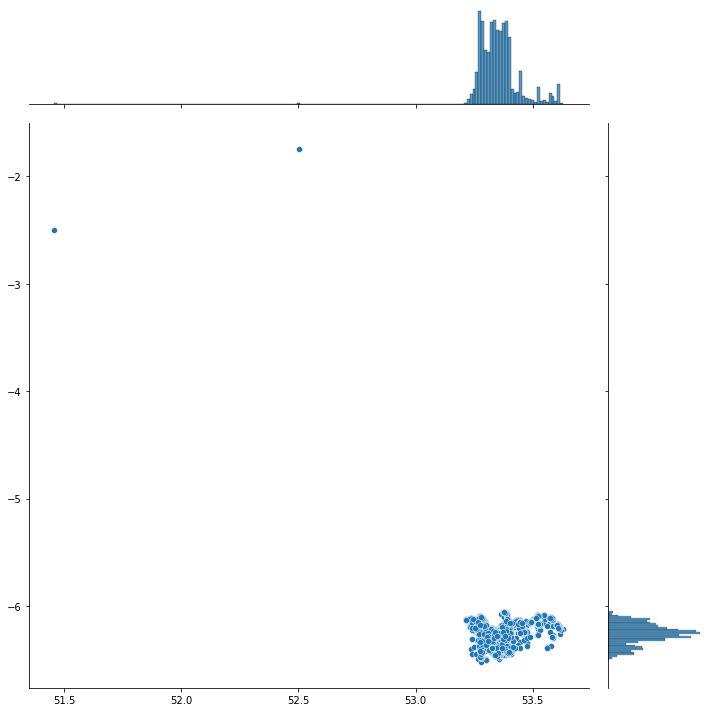

<function seaborn.utils.despine>

In [85]:
# plot the the latitude and longitude attributes (https://deepnote.com/@jz/House-prices-prediction-DuSZvuoNSEmb5cCKcsW4BQ)
plt.figure(figsize=(10,10))
sns.jointplot(x=df_train.latitude.values, y=df_train.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
sns.despine

The houses for sale are concentrated in quite a small area however there are two outliers which we will remove, essentially the two that are greater than longitude of '-6' and latitude less than '53.0'.

Let's remove these outliers from the dataset.


In [86]:
index_train = df_train[(df_train['longitude'] > -6.0)|(df_train['latitude'] < 53.0)].index
index_test = df_test[(df_test['longitude'] > -6.0)|(df_test['latitude'] < 53.0)].index
df_train.drop(index_train, inplace=True)
df_test.drop(index_test, inplace=True)
df_train['longitude'].describe()

count    2980.000000
mean    -6.259952   
std      0.092524   
min     -6.521183   
25%     -6.314104   
50%     -6.252267   
75%     -6.196090   
max     -6.054719   
Name: longitude, dtype: float64

<Figure size 720x720 with 0 Axes>

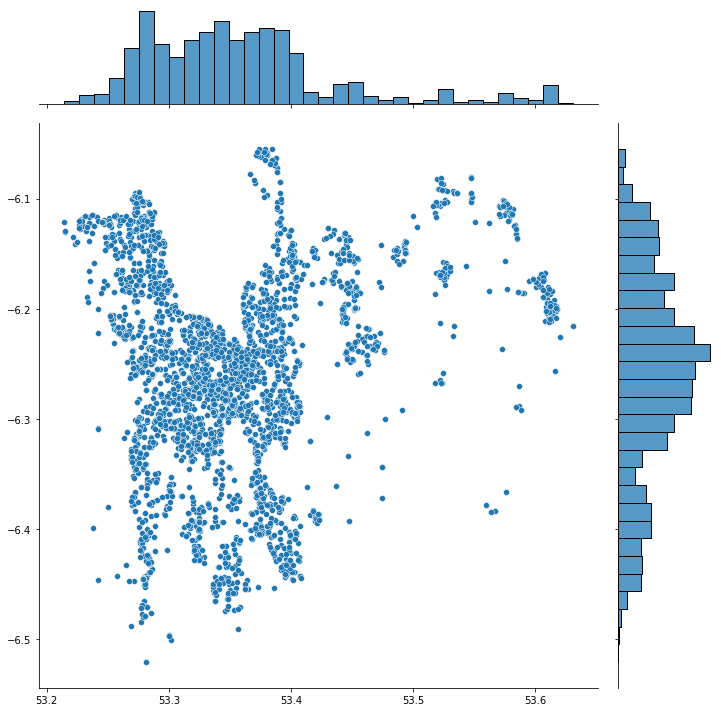

<function seaborn.utils.despine>

In [87]:
# plot the the latitude and longitude attributes (https://deepnote.com/@jz/House-prices-prediction-DuSZvuoNSEmb5cCKcsW4BQ)
plt.figure(figsize=(10,10))
sns.jointplot(x=df_train.latitude.values, y=df_train.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
sns.despine

Eliminating the longitude and latitude outliers presents us with a very clean view of remaining data with a high concentration of houses between longitude 6.1 and 6.35 and latitude 53.25 and 53.42. But let's also check the number of distinct categories per attribute, that is, the cardinality:

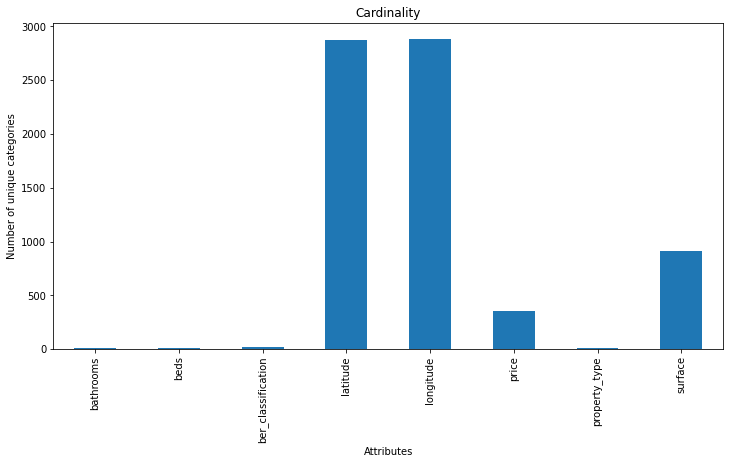

In [95]:
# plot the cardinality of the attributes

df_train.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.xlabel('Attributes')
plt.title('Cardinality')
plt.show()

Based on previous observations and the attribute cardinality we will check the following attributes for outliers; area,	bathrooms, beds, ber_classification	latitude, longitude, price, property_type, surface

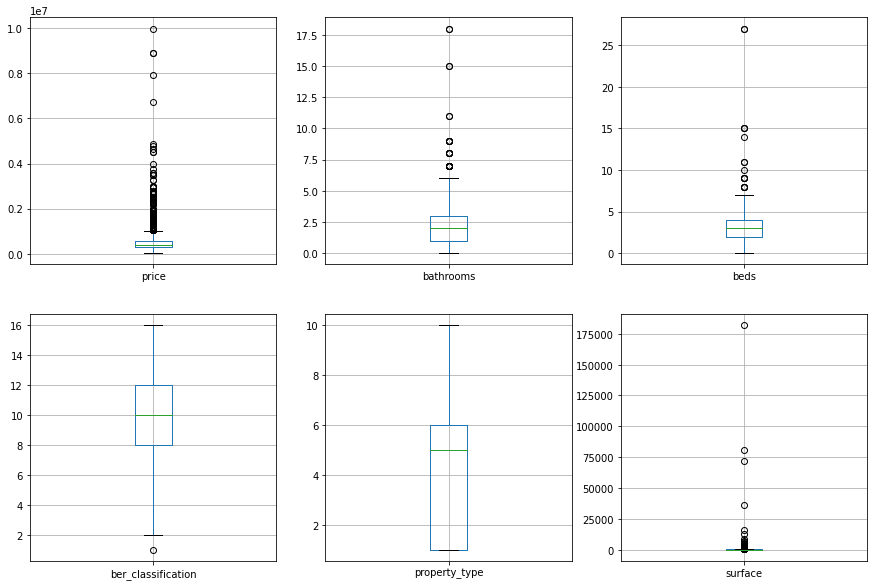

In [98]:
# plot a boxplot of the attributes price, bathrooms, beds, ber_classification, property_type, surface

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 3, 1)
df_train.boxplot(column='price')
ax2 = fig.add_subplot(2, 3, 2)
df_train.boxplot(column='bathrooms')
ax3 = fig.add_subplot(2, 3, 3)
df_train.boxplot(column='beds')
ax4 = fig.add_subplot(2, 3, 4)
df_train.boxplot(column='ber_classification')
ax5 = fig.add_subplot(2, 3, 5)
df_train.boxplot(column='property_type')
ax6 = fig.add_subplot(2, 3, 6)
df_train.boxplot(column='surface')
plt.show()

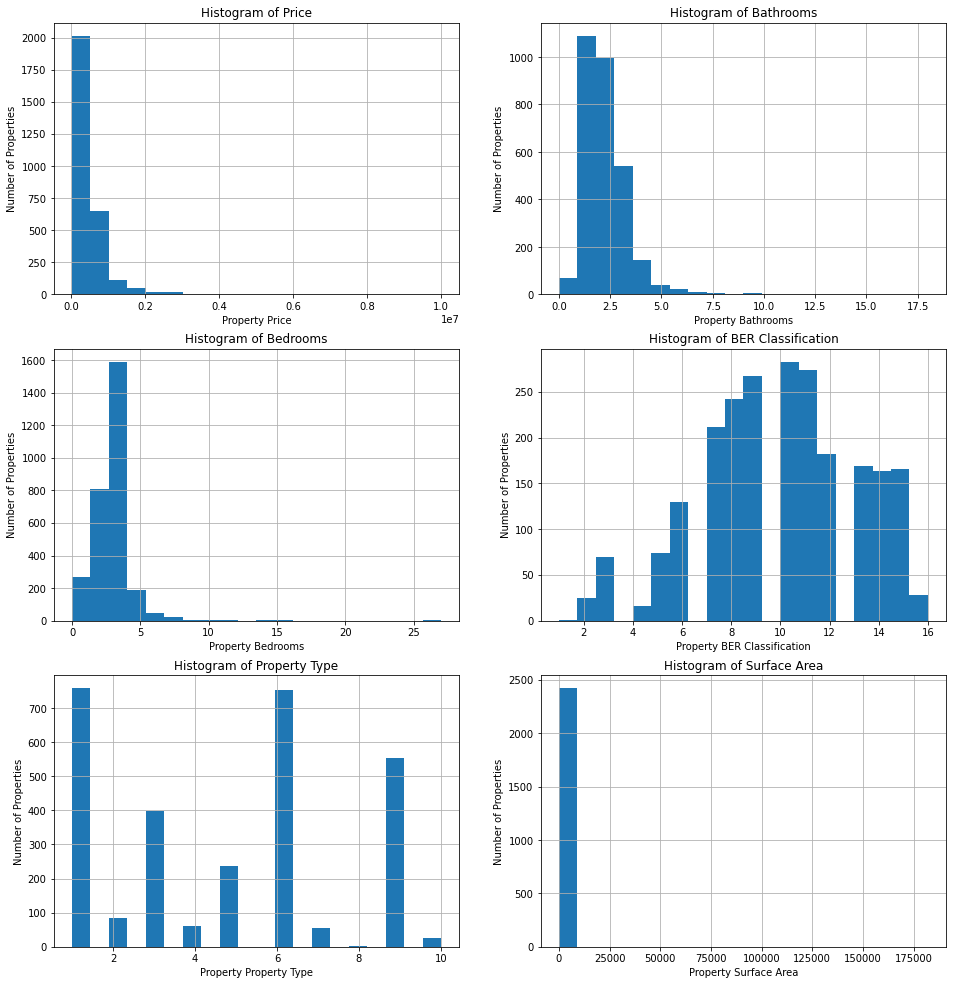

In [100]:
# plot the histograms for the attributes price, bathrooms, beds, ber_classification, property_type, surface

fig = plt.figure(figsize=(16,35))

ax1 = fig.add_subplot(6, 2, 1)
ax1.set_title("Histogram of Price")
ax1.set_xlabel('Property Price')
ax1.set_ylabel('Number of Properties')
df_train['price'].hist(bins=20)

ax2 = fig.add_subplot(6, 2, 2)
ax2.set_title("Histogram of Bathrooms")
ax2.set_xlabel('Property Bathrooms')
ax2.set_ylabel('Number of Properties')
df_train['bathrooms'].hist(bins=20)

ax3 = fig.add_subplot(6, 2, 3)
ax3.set_title("Histogram of Bedrooms")
ax3.set_xlabel('Property Bedrooms')
ax3.set_ylabel('Number of Properties')
df_train['beds'].hist(bins=20)

ax4 = fig.add_subplot(6, 2, 4)
ax4.set_title("Histogram of BER Classification")
ax4.set_xlabel('Property BER Classification')
ax4.set_ylabel('Number of Properties')
df_train['ber_classification'].hist(bins=20)

ax5 = fig.add_subplot(6, 2, 5)
ax5.set_title("Histogram of Property Type")
ax5.set_xlabel('Property Property Type')
ax5.set_ylabel('Number of Properties')
df_train['property_type'].hist(bins=20)

ax6 = fig.add_subplot(6, 2, 6)
ax6.set_title("Histogram of Surface Area")
ax6.set_xlabel('Property Surface Area')
ax6.set_ylabel('Number of Properties')
df_train['surface'].hist(bins=20)

plt.show()

There are clearly outliers for the bedroom and bathroom attributes. We will remove those registers that have great than either 6 bedrooms or bathrooms.

In [107]:
# let's check the bathrooms values
df_train.bathrooms.drop_duplicates()

0    NaN 
15    3.0
26    4.0
35    5.0
38    2.0
56    0.0
59    1.0
69    6.0
Name: bathrooms, dtype: float64

In [106]:
# remove registers with greater than 6 bathrooms (https://medium.com/@harsz89/how-to-drop-rows-based-on-column-values-using-pandas-dataframe-38cf50e4c95a)
indexNames = df_train[df_train['bathrooms'] >= 7].index
df_train.drop(indexNames , inplace=True)

In [110]:
# let's check the bathrooms values
df_train.bathrooms.drop_duplicates()

0    NaN 
15    3.0
26    4.0
35    5.0
38    2.0
56    0.0
59    1.0
69    6.0
Name: bathrooms, dtype: float64

In [109]:
# let's check the bedrooms values
df_train.beds.drop_duplicates()

0      NaN  
15      5.0 
26      4.0 
38      2.0 
56      0.0 
59      1.0 
61      3.0 
69      6.0 
116     7.0 
144     9.0 
472     14.0
2202    15.0
Name: beds, dtype: float64

In [112]:
# remove registers with greater than 6 bedrooms (https://medium.com/@harsz89/how-to-drop-rows-based-on-column-values-using-pandas-dataframe-38cf50e4c95a)
indexNames = df_train[df_train['beds'] >= 7].index
df_train.drop(indexNames , inplace=True)

In [113]:
# let's check the bedrooms values
df_train.beds.drop_duplicates()

0    NaN 
15    5.0
26    4.0
38    2.0
56    0.0
59    1.0
61    3.0
69    6.0
Name: beds, dtype: float64

In [114]:
print("The training dataframe is of shape", (df_train.shape))
print("The testing dataframe is of shape", (df_test.shape))
print("The cost dataframe is of shape", (df_cost.shape))

The training dataframe is of shape (2938, 8)
The testing dataframe is of shape (500, 7)
The cost dataframe is of shape (500, 2)


In [115]:
#  as the area attribute is a duplication of the longitude and latidue information we can drop it and avoid ordinal encoding of it

df_train.drop('area', axis=1, inplace=True)
df_test.drop('area', axis=1, inplace=True)

KeyError: ignored

In [116]:
print("The training dataframe is of shape", (df_train.shape))
print("The testing dataframe is of shape", (df_test.shape))
print("The cost dataframe is of shape", (df_cost.shape))

The training dataframe is of shape (2938, 8)
The testing dataframe is of shape (500, 7)
The cost dataframe is of shape (500, 2)


In [92]:
df_train.tail()

,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
2977,2.0,2.0,9.0,53.338738,-6.237199,415000.0,1.0,56.0
2978,1.0,3.0,5.0,53.335793,-6.294268,485000.0,9.0,101.0
2979,1.0,2.0,9.0,53.346098,-6.276856,299000.0,1.0,55.6
2980,2.0,3.0,9.0,53.273518,-6.178500,495000.0,5.0,97.0
2981,2.0,3.0,11.0,53.310073,-6.325158,525000.0,6.0,129.3


In [117]:
#  check for missing values 

print('Number of missing values for each attribute')
df_train.isna().sum()

Number of missing values for each attribute


bathrooms             51 
beds                  51 
ber_classification    656
latitude              0  
longitude             0  
price                 87 
property_type         51 
surface               539
dtype: int64

Let's remove the registers with 0 bathrooms and 0 bedrooms.

In [118]:
# remove registers with 0 bathrooms
df_train.dropna(subset=['bathrooms'], inplace=True)

In [119]:
#  check for missing values 

print('Number of missing values for each attribute')
df_train.isna().sum()

Number of missing values for each attribute


bathrooms             0  
beds                  0  
ber_classification    605
latitude              0  
longitude             0  
price                 36 
property_type         0  
surface               488
dtype: int64

This actually removed all rows that had 0 bathrooms, 0 bedrooms and also missing  values for property_type so they were all the same rows.

In [ ]:
Replace the missing values for the ber_classification attribute with the most frequently occuring value

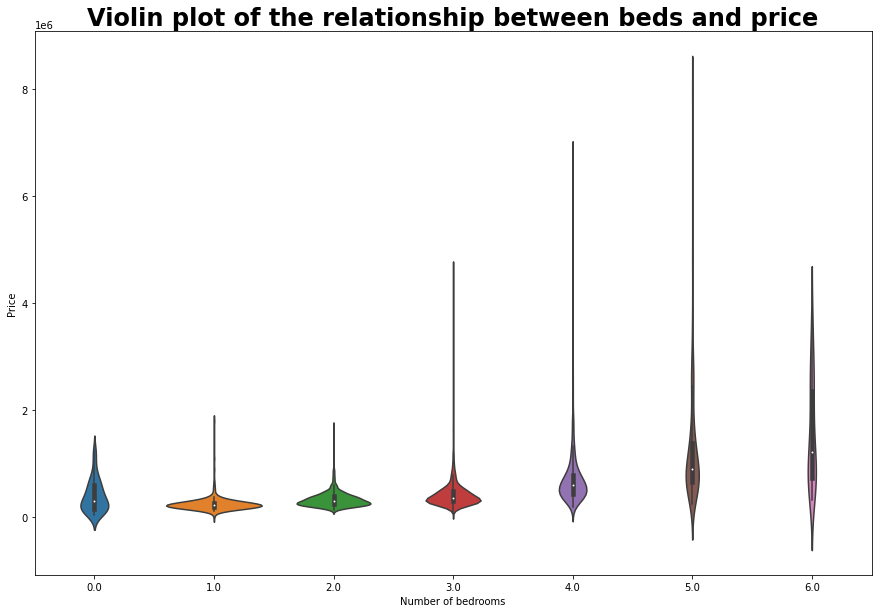

In [120]:
# examine the relationship between price and beds using a violin plot

sns.violinplot(data=df_train, x='beds', y='price')
plt.title('Violin plot of the relationship between beds and price', fontdict= { 'fontsize': 24, 'fontweight':'bold'})
plt.xlabel('Number of bedrooms')
plt.ylabel('Price')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

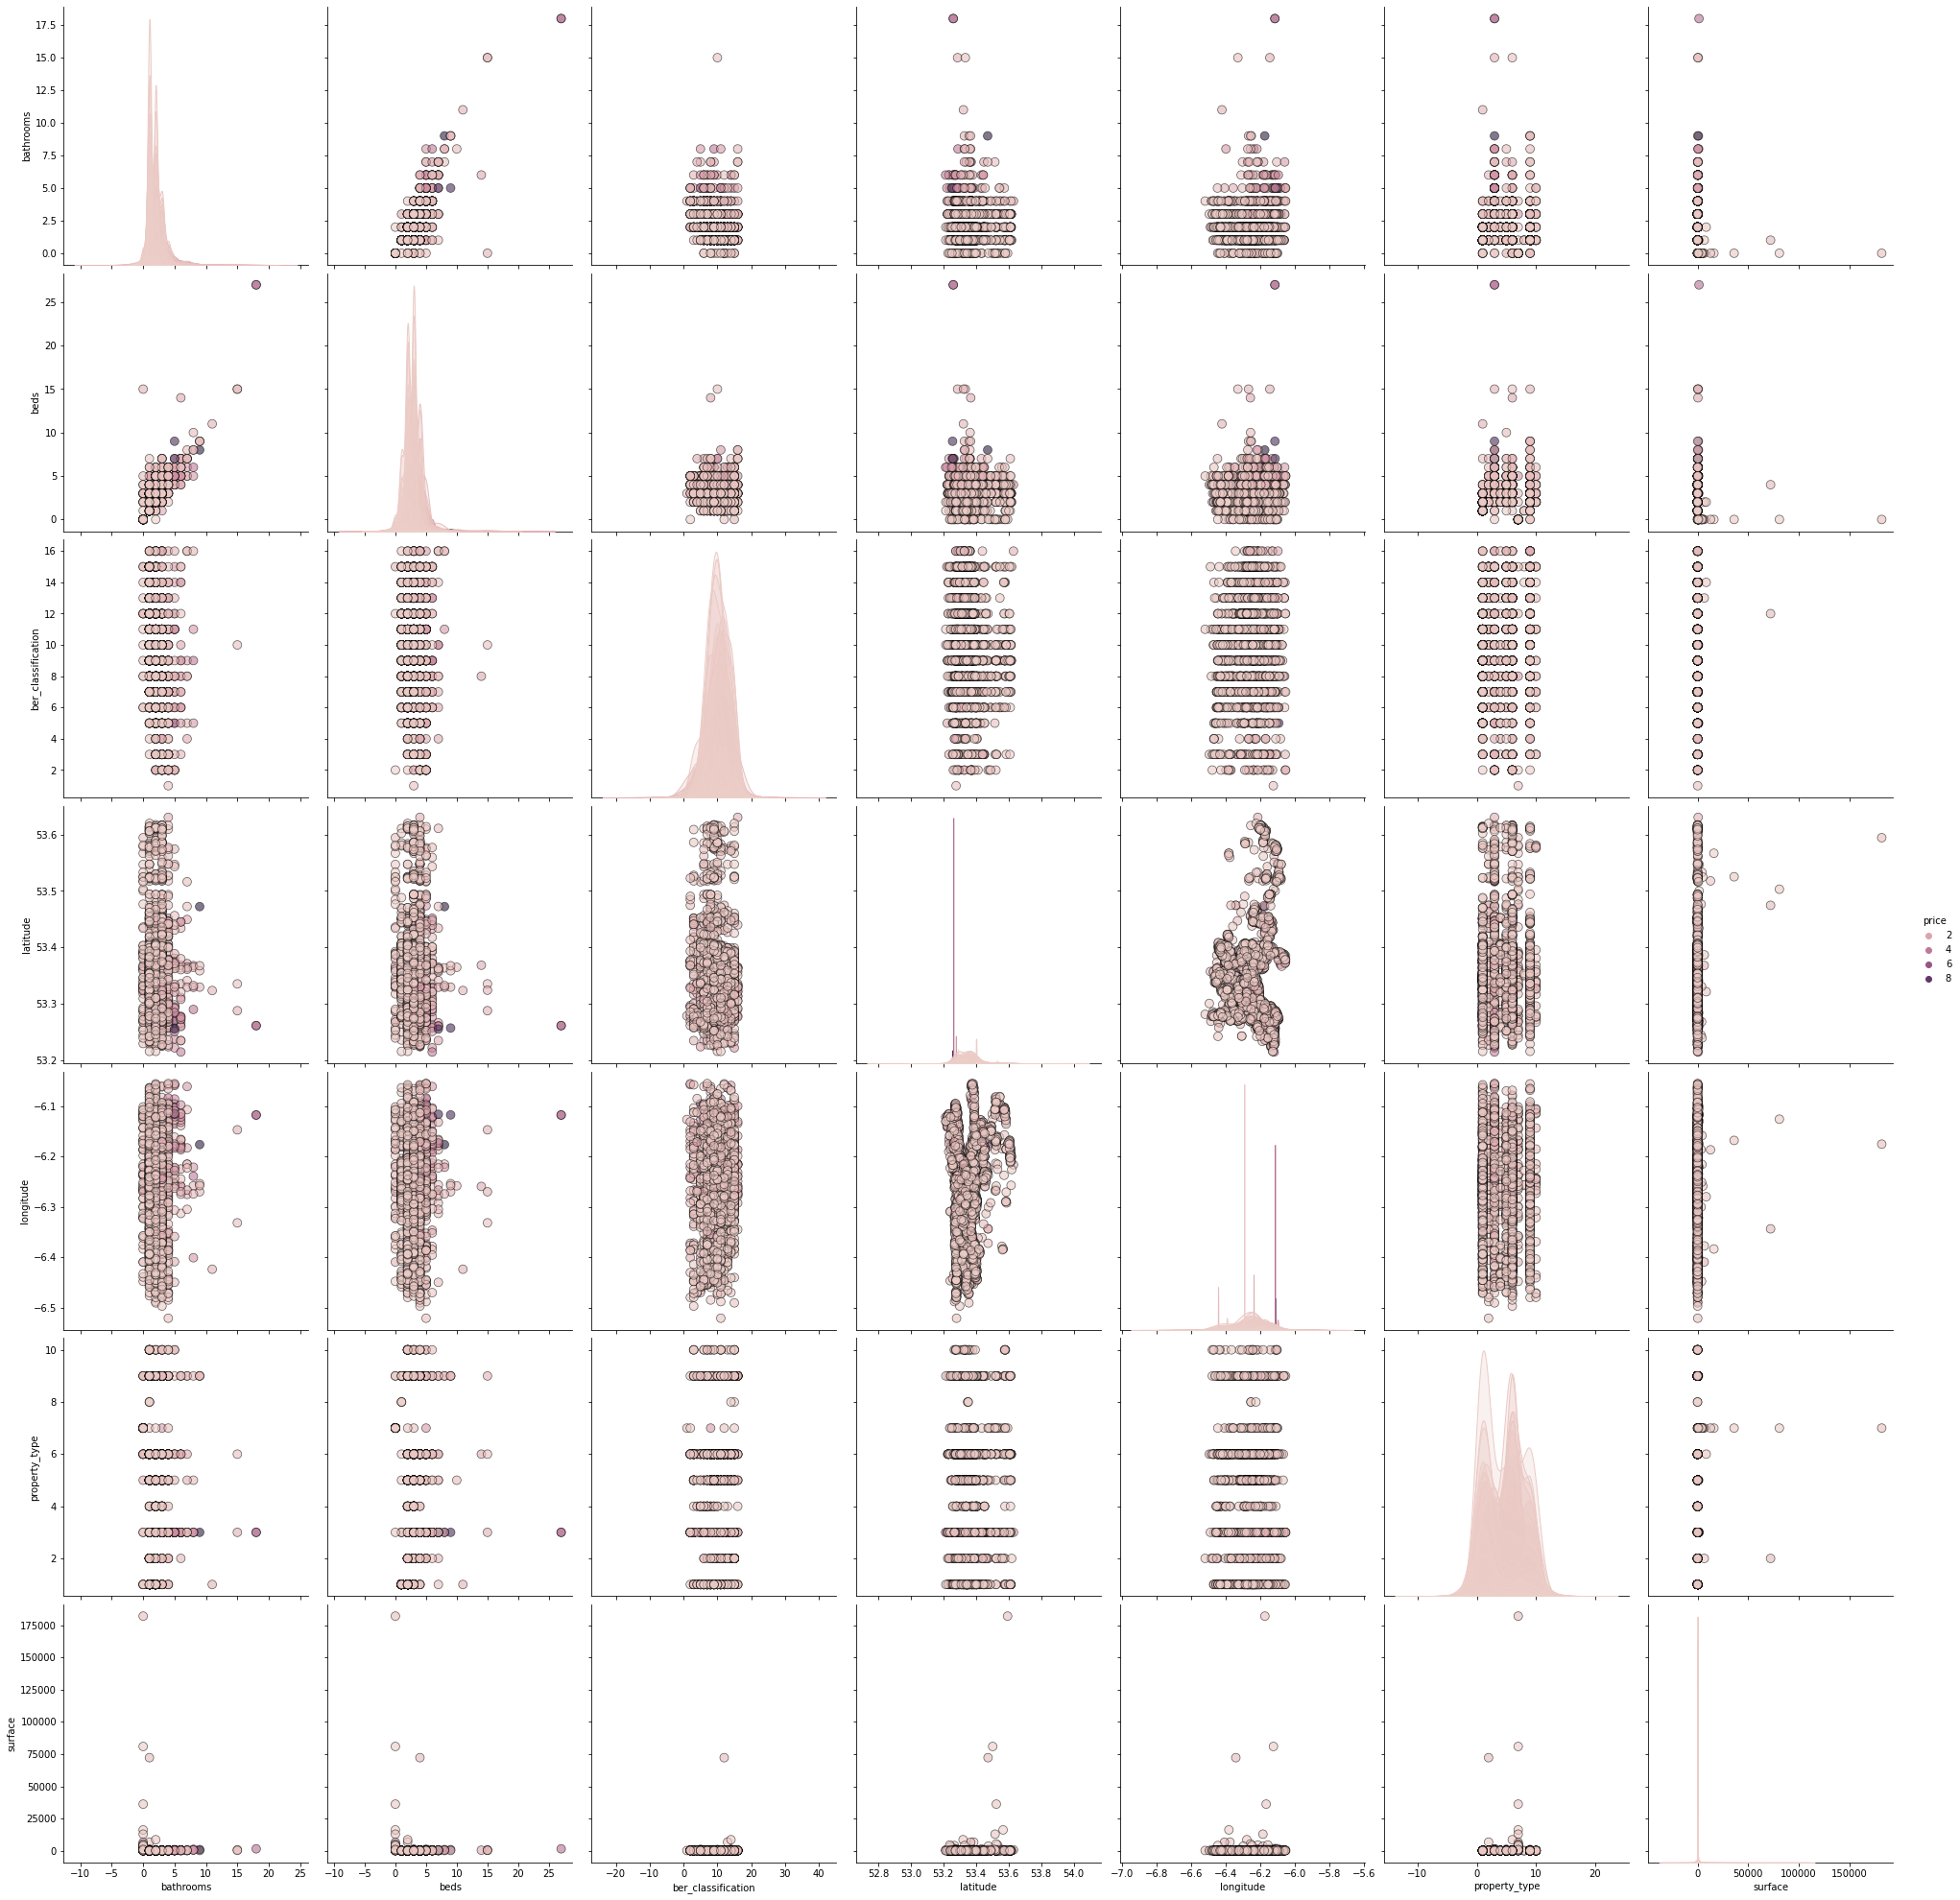

In [46]:
 # use pairplots to research two numerical attributes that can potentially be used for predicting price

sns.pairplot(data=df_train, vars=['bathrooms', 'beds',	'ber_classification',	'latitude', 'longitude', 'property_type', 'surface'], hue = 'price', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
plt.show()

In [43]:
 # split data into training and test
from sklearn.model_selection import train_test_split

y = df_train['price']
X = df_train.drop('price', axis=1).values
# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

## Training & Test Data

### Train dataset

### Expected Cost dataset

# PIECEWISE REGRESSION

## Full Model

In [44]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['bathrooms', 'beds', 'ber_classification', 'longitude', 'latitude', 'surface','price']
# dropna: remove missing values
df_subset_train = df_train[featrain].dropna(axis=0)

featest = ['bathrooms', 'beds', 'ber_classification', 'longitude', 'latitude','surface']
df_subset_test  =  df_test[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

print(df_subset_train.shape)
print(df_subset_test.shape)
print(df_cost.shape)

(2002, 7)
(444, 6)
(444, 2)


In [45]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [46]:

print(df_cost.describe())
df_cost.tail()

                 Id      Expected
count  4.440000e+02  4.440000e+02
mean   1.231937e+07  5.449691e+05
std    1.400218e+05  4.696690e+05
min    1.149085e+07  1.250000e+05
25%    1.228617e+07  2.950000e+05
50%    1.237928e+07  4.250000e+05
75%    1.240564e+07  5.950000e+05
max    1.242809e+07  5.250000e+06


,Id,Expected
494,12385192,625000.0
496,12416011,775000.0
497,12232222,360000.0
498,11905630,925000.0
499,12394865,325000.0


In [ ]:
print('Number of missing values for each attribute')
df.isna().sum()

In [47]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.Expected.values

In [48]:
print("The training set input is of shape", (Xs_train.shape))
print("The testing set output is of shape", (ys_train.shape))
print("The testing set input is of shape", (Xs_test.shape))
print("The testing set output is of shape", (y_test.shape))

The training set input is of shape (2002, 6)
The testing set output is of shape (2002, 1)
The testing set input is of shape (444, 6)
The testing set output is of shape (444,)


In [49]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [50]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 1,972.7


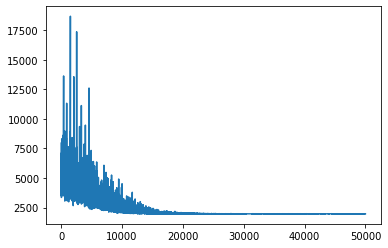

In [51]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [52]:
# samples from the posterior
posterior = approximation.sample(5000)

In [53]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  174362.0076747574
MAPE =  0.26896907851563795


## Clustering

### Full Model

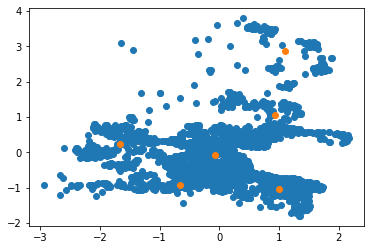

In [54]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6)

# clustering by features 3 and 4 which is longitude and latitude so essentially location, location, location!
ind=[3,4]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])


### Clusters

In [58]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))



{0: 895, 1: 116, 2: 243, 3: 210, 4: 342, 5: 196}

In [59]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))


{0: 207, 1: 37, 2: 43, 3: 43, 4: 77, 5: 37}

In [60]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [61]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [62]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [63]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [64]:
# cluster 4
Xn4 = Xn_train[clusters_train==4,:]
Xtestn4 = Xn_test[clusters_test==4,:]
ylog4 = np.log(ys_train.astype('float')[clusters_train==4,:])
yscaler4 = StandardScaler().fit(ylog4)
yn4 = yscaler3.transform(ylog4)

In [65]:
# cluster 5
Xn5 = Xn_train[clusters_train==5,:]
Xte5 = Xn_test[clusters_test==5,:]
ylog5 = np.log(ys_train.astype('float')[clusters_train==4,:])
yscaler5 = StandardScaler().fit(ylog5)
yn5 = yscaler3.transform(ylog5)

## Piecewise Model

In [66]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 869.99


In [67]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])

with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 152.74


In [68]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn2
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])

with model_2:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 256.14


In [69]:
# model_3
with pm.Model() as model_3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn3
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn3.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])

with model_3:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 175.69


In [70]:
# model_4
with pm.Model() as model_4:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn4
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn4.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn4.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn4[:,0])

with model_4:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior4 = approximation.sample(5000)

Finished [100%]: Average Loss = 395.7


In [73]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



##Simulations

### Only Cluster 0

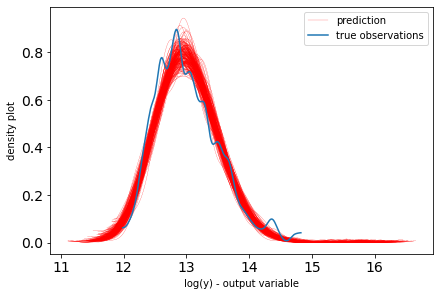

In [74]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Only Cluster **1**

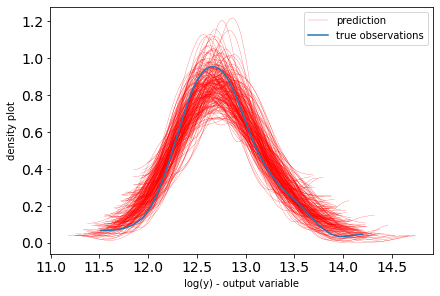

In [75]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Only Cluster **2**

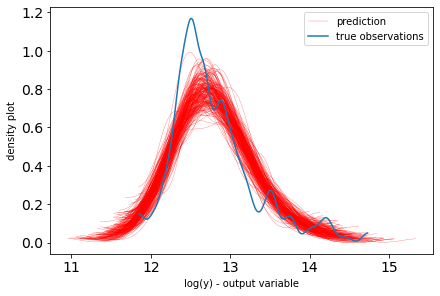

In [76]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Only Cluster **3**

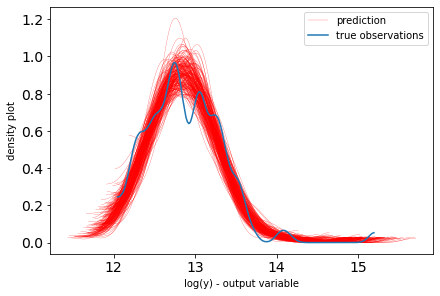

In [77]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Only Cluster 4

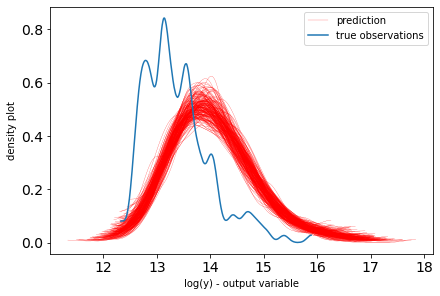

In [78]:
#Simulation
Ypred4 = yscaler4.inverse_transform(ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200))
for i in range(Ypred4.shape[0]):
    az.plot_dist( Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog4,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

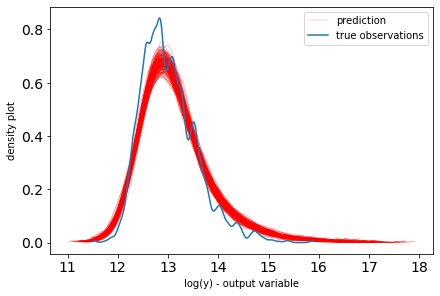

In [79]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3, ylog4])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [84]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# cluster 4
y_pred_BLR3 = np.exp(yscaler4.inverse_transform(np.mean(posterior4['alpha']) 
              + np.dot(np.mean(posterior4['beta'],axis=0), Xtestn4.T)))
print("Size Cluster4", np.sum(clusters_test==4), ", MAE Cluster4=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==4]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR3 - y_test[clusters_test==4])])


# MAE
print("MAE=",np.mean(joint))

Size Cluster0 207 , MAE Cluster0= 151962.40544755882
Size Cluster1 37 , MAE Cluster1= 141409.97001035314
Size Cluster2 43 , MAE Cluster2= 109403.7565410962
Size Cluster3 43 , MAE Cluster3= 62945.69106633704
Size Cluster4 77 , MAE Cluster4= 712423.4190526634


ValueError: ignored

### PPC on the Test set



# SUMMARY